Epoch: 0
Train - Loss: 656.9047 Accuracy: 0.7509
Valid - Loss: 83.2002 Accuracy: 0.8554
Epoch: 1
Train - Loss: 108.0846 Accuracy: 0.9596
Valid - Loss: 35.3639 Accuracy: 0.9483
Epoch: 2
Train - Loss: 61.2073 Accuracy: 0.9777
Valid - Loss: 19.9628 Accuracy: 0.9704
Epoch: 3
Train - Loss: 44.3084 Accuracy: 0.9840
Valid - Loss: 21.5225 Accuracy: 0.9706
Epoch: 4
Train - Loss: 34.6407 Accuracy: 0.9872
Valid - Loss: 30.5038 Accuracy: 0.9462
Epoch: 5
Train - Loss: 33.5703 Accuracy: 0.9877
Valid - Loss: 12.8339 Accuracy: 0.9763
Epoch: 6
Train - Loss: 25.4352 Accuracy: 0.9900
Valid - Loss: 18.0898 Accuracy: 0.9677
Epoch: 7
Train - Loss: 20.9299 Accuracy: 0.9913
Valid - Loss: 6.8997 Accuracy: 0.9881
Epoch: 8
Train - Loss: 23.8917 Accuracy: 0.9904
Valid - Loss: 12.6243 Accuracy: 0.9785
Epoch: 9
Train - Loss: 15.9112 Accuracy: 0.9941
Valid - Loss: 12.1756 Accuracy: 0.9796
Epoch: 10
Train - Loss: 21.3783 Accuracy: 0.9926
Valid - Loss: 25.7378 Accuracy: 0.9682
Epoch: 11
Train - Loss: 15.1081 Accuracy:

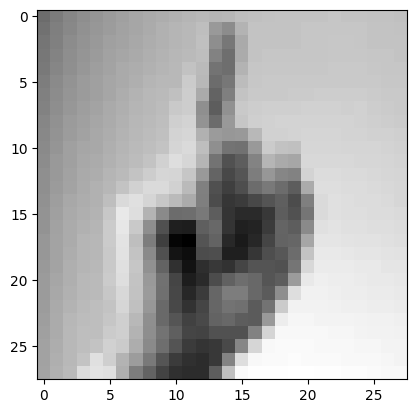

In [11]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available

IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

model = torch.compile(base_model.to(device))
model

row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)


random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])

new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')


def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_transforms(x))  # Updated
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += utils.get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))


def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += utils.get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()
torch.save(base_model, 'model.pth')

In [14]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

'b'

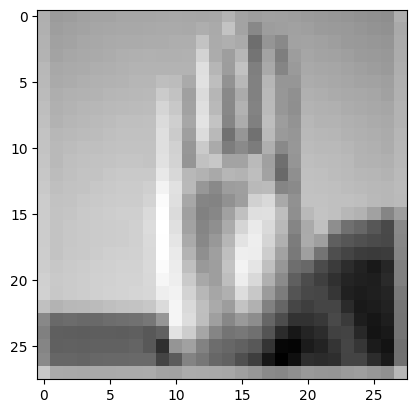

In [10]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.io as tv_io
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

from utils import MyConvBlock

model = torch.load('model.pth', map_location=device)
model
next(model.parameters()).device

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

show_image('data/asl_images/b.png')

image = tv_io.read_image('data/asl_images/b.png', tv_io.ImageReadMode.GRAY)

IMG_WIDTH = 28
IMG_HEIGHT = 28

preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()  # From Color to Gray
])

processed_image = preprocess_trans(image)
processed_image

processed_image.shape

plot_image = F.to_pil_image(processed_image)
plt.imshow(plot_image, cmap='gray')
batched_image = processed_image.unsqueeze(0)
batched_image.shape
batched_image_gpu = batched_image.to(device)
batched_image_gpu.device
output = model(batched_image_gpu)
output



def predict_letter(file_path):
    # Show image
    show_image(file_path)
    # Load and grayscale image
    image = tv_io.read_image(file_path, tv_io.ImageReadMode.GRAY)
    # Transform image
    image = preprocess_trans(image)
    # Batch image
    image = image.unsqueeze(0)
    # Send image to correct device
    image = image.to(device)
    # Make prediction
    output = model(image)
    # Find max index
    prediction = output.argmax(dim=1).item()
    # Convert prediction to letter
    predicted_letter = alphabet[prediction]
    # Return prediction
    return predicted_letter

